In [1]:
import sys
home_dir = '../'
sys.path.append(home_dir)
print(sys.path)

import pandas as pd
np = pd.np
from pymongo import MongoClient
from datetime import datetime, timedelta

from steevebase.io import load_sequence, save_sequence

client = MongoClient('mongodb://107.155.87.82:26999')
# client = MongoClient('mongodb://localhost:26999')
db = client.get_database('steem_posts')
db.authenticate("admin","dmw]SR%u6Ct!", source='admin')
raw_posts_col = db.get_collection("raw_posts")

['', '/root/miniconda3/lib/python36.zip', '/root/miniconda3/lib/python3.6', '/root/miniconda3/lib/python3.6/lib-dynload', '/root/.local/lib/python3.6/site-packages', '/root/miniconda3/lib/python3.6/site-packages', '/root/steem_ailib', '/root/steem_ailib/steem-python', '/root/miniconda3/lib/python3.6/site-packages/IPython/extensions', '/root/.ipython', '../']


### Get hr1's shares on a given post - at T+30

In [12]:
from steevebase.io import get_post
from rshares import get_share_hr1

hr1_voting_rshares = 2 * 5225094432163 # voted on 2nd of May 2018 when voting power on 50% exactly
'%g' % hr1_voting_rshares

'1.04502e+13'

In [125]:
burnpost_106 = get_post('burnpost/steem-experiment-burn-post-106')

In [126]:
_, percent = get_share_hr1(burnpost_106.export(), hr1_voting_rshares)
percent

hr1 already voted
weight_total: 7925085


0.07859600244035238

In [92]:
900 * 0.25 * 0.0786 * 20 / 3.840402

92.09973330916921

In [100]:
def magic_formula(p0, p1, pt, weight_fct=np.sqrt):
    return 0.25 * weight_fct(pt) * (weight_fct(p1) - weight_fct(p0))

def daily_steem_magic(p0, p1, pt, steem_price=3.86):
    return 20 * magic_formula(p0, p1, pt) / steem_price

In [133]:
p0 = 32.48
p1 = 65.76
pt = 900

In [139]:
magic_formula(p0, p1, pt)

18.075984251814866

In [140]:
daily_steem_magic(p0, p1, pt)

93.65794949126875

#### probably wrong:

In [146]:
_, percent = get_share_hr1(burnpost_106.export(), hr1_voting_rshares * 0.5, voting_time=datetime.utcnow())
percent

injecting hr1 with voting time: 2018-05-03 08:45:54.510986
weight_total: 7925085


0.03929800122017619

In [128]:
burnpost_108 = get_post('burnpost/steem-experiment-burn-post-108')

In [129]:
_, percent = get_share_hr1(burnpost_108.export(), hr1_voting_rshares)
percent

hr1 already voted
weight_total: 3340854


0.31836081433070706

In [132]:
percent * p1 * 0.25 / 3.86

1.3559201522271567

In [145]:
import copy

# weight_fct = np.sqrt

def approx_sqrt_v1(x):
    if x <= 1:
        return x
    # mantissa_bits, leading_1, mantissa_mask are independent of x
    msb_x = x.bit_length() - 1
    msb_z = msb_x >> 1
    msb_x_bit = 1 << msb_x
    msb_z_bit = 1 << msb_z
    mantissa_mask = msb_x_bit-1

    mantissa_x = x & mantissa_mask
    if (msb_x & 1) != 0:
        mantissa_z_hi = msb_z_bit
    else:
        mantissa_z_hi = 0
    mantissa_z_lo = mantissa_x >> (msb_x - msb_z)
    mantissa_z = (mantissa_z_hi | mantissa_z_lo) >> 1
    result = msb_z_bit | mantissa_z
    return result

def remove_hr1(post):
    changed_post = post.copy()
    for i, p in enumerate(post['active_votes']):
        if p['voter'] == 'hr1':
            changed_post['active_votes'] = post['active_votes'][:i] + post['active_votes'][i+1:]
            break
    
    return changed_post

def parse_voting(active_votes):
    for vote in active_votes:
        vote['rshares'] = int(vote['rshares'])
        if isinstance(vote['time'], str):
            vote['time'] = datetime.strptime(vote['time'], '%Y-%m-%dT%H:%M:%S')

    return active_votes

def recalculate_weights(active_votes, created):
    rshares_total = 0
    weight_total = 0
    weight_hr1 = 0
       
    for i, vote in enumerate(active_votes):
        w_before = weight_fct(rshares_total)
        
        rshares_total += vote['rshares']
        rshares_total = max(0, rshares_total)
        
        w = weight_fct(rshares_total) - w_before
        w = max(0, w)
        
        delay = (vote['time'] - created).total_seconds()
        delay_coeff = min(1, delay / (30*60))
        
#         w *= delay_coeff

        # total weight calculated as without delay coefficient (just the proceeds go to the author, not curator)
        vote['weight'] = w
        weight_total += w
        
        # here apply the coeff to get correct weight for the curator
        w *= delay_coeff
        
        if vote['voter'] == 'hr1':
            weight_hr1 = w
    
    weighted_rshares = 0
    
    print('weight_total:', weight_total)
    
    if weight_total > 0:
        percent = weight_hr1 / weight_total
        weighted_rshares = percent * rshares_total
    
    return weighted_rshares, percent

def inject_hr1(post, rshares_hr1, voting_time):
    hr_vote = {
        'voter': 'hr1',
        'rshares': rshares_hr1,
        'time': voting_time
    }
    
    injected = False
    for i, vote in enumerate(post['active_votes']):
        if vote['time'] > voting_time:
            post['active_votes'] = post['active_votes'][:i] + \
                                    [hr_vote] + \
                                    post['active_votes'][i+1:]
            injected = True
            break
    
    if not post['active_votes']:
        post['active_votes'] = [hr_vote]
        
    elif not injected:
        post['active_votes'] += [hr_vote]

def get_share_hr1(post, rshares_hr1, voting_time=None):
    
    rshares_hr1 = int(rshares_hr1)
    
    changed_post = copy.deepcopy(post)
    
    created = changed_post['created']
    # parse times
    changed_post['active_votes'] = parse_voting(changed_post['active_votes'])
    # sort wrt times
    changed_post['active_votes'] = sorted(changed_post['active_votes'], key=lambda x: x['time'])
    
    hr1_is_in = 'hr1' in set(x['voter'] for x in changed_post['active_votes'])
    
    if hr1_is_in and voting_time is None:
        print('hr1 already voted')
    else:
        print('injecting hr1 with voting time:', voting_time)
    
        changed_post = remove_hr1(changed_post)

        if voting_time is None:
            voting_time = created + timedelta(seconds=VOTING_DELAY)

        inject_hr1(changed_post, rshares_hr1, voting_time)
    
    hr1_reward, percent = recalculate_weights(changed_post['active_votes'], created)
        
    return hr1_reward, percent

weight_fct = approx_sqrt_v1

In [86]:
_, percent = get_share_hr1(burnpost.export(), hr1_voting_rshares)
percent

hr1 already voted
weight_total: 3366271.671666667


0.1850355707302754

In [78]:
sorted(burnpost['active_votes'], key=lambda x: x['time'])[-5:]

[{'voter': 'adasq',
  'weight': 420,
  'rshares': 3524107287,
  'percent': 10000,
  'reputation': '11624101282065',
  'time': '2018-05-02T07:20:00'},
 {'voter': 'enmaart',
  'weight': 2475,
  'rshares': '20764673445',
  'percent': 10000,
  'reputation': '3258903316738',
  'time': '2018-05-02T07:48:33'},
 {'voter': 'hr1',
  'weight': 622880,
  'rshares': '5225094432163',
  'percent': 10000,
  'reputation': '6856858218780',
  'time': '2018-05-02T13:06:18'},
 {'voter': 'sheskates926',
  'weight': 137,
  'rshares': 1149986448,
  'percent': 10000,
  'reputation': '214426439989',
  'time': '2018-05-02T13:12:39'},
 {'voter': 'upmyvote',
  'weight': 521667,
  'rshares': '4376055892958',
  'percent': 10000,
  'reputation': '367118694444',
  'time': '2018-05-02T15:34:12'}]

In [50]:
103 * 0.25 * 0.1549

3.988675

In [ ]:
burnpost = get_post('burnpost/steem-experiment-burn-post-104')

In [17]:
_, percent = get_share_hr1(burnpost.export(), hr1_voting_rshares)
percent

0.14470771815915068

In [18]:
_, percent = get_share_hr1(burnpost.export(), hr1_voting_rshares, voting_time=datetime.utcnow())
percent

0.03699900072688547

In [6]:
(103.81 - 70.19)*2

67.24000000000001

In [55]:
try:
    raise RuntimeError('heheheh')
except RuntimeError as e:
    print(type(e))

<class 'RuntimeError'>


In [58]:
e = RuntimeError('heheheh')

In [60]:
e.args[0]

'heheheh'

### end

In [3]:
data_bin = load_sequence(home_dir + "data/data.jsonl")
# data_bin = load_sequence(home_dir + "posts_2017_11_23_labeled.jsonl")
len(data_bin)

115011

In [4]:
data_bin[0].keys()

dict_keys(['title', 'body', 'net_votes', 'target', 'url'])

### Find the same way as in wrangler

In [3]:
start_time = '2017-11-10 08:11:12'
end_time = '2017-11-22 06:17:09'

TIME_FORMAT = '%Y-%m-%d %H:%M:%S'

ineq_dict = {}

if start_time:
    ineq_dict['$gte'] = datetime.strptime(start_time, TIME_FORMAT)

if end_time:
    ineq_dict['$lte'] = datetime.strptime(end_time, TIME_FORMAT)

if ineq_dict:
    query = {'created': ineq_dict}

# raw_posts_col.find_one(query)
data_timedelta = (ineq_dict['$lte'] - ineq_dict['$gte']).total_seconds() / 3600 / 24
print('Data gathered over %.2f days' % data_timedelta)

Data gathered over 11.92 days


### Find the raw posts from urls in training data

In [5]:
ids = [x['url'].split('/', maxsplit=2)[2] for x in data_bin]
# ids

In [6]:
query = {
    '_id': {
        '$in': ids
    }
}
raw_posts = [x for x in raw_posts_col.find(query)]

In [7]:
len(raw_posts)

115011

In [33]:
raw_posts[0]['active_votes']['voter']

[{'percent': 10000,
  'reputation': '55878026456',
  'rshares': 411980800,
  'time': '2017-11-17T16:10:09',
  'voter': 'boyhaqi97',
  'weight': 3143},
 {'percent': 10000,
  'reputation': 2911025705,
  'rshares': 906262706,
  'time': '2017-11-17T16:05:15',
  'voter': 'armagno',
  'weight': 6914},
 {'percent': 10000,
  'reputation': 2756168581,
  'rshares': 619153349,
  'time': '2017-11-16T21:02:00',
  'voter': 'natochka',
  'weight': 25831},
 {'percent': 10000,
  'reputation': '2611379181440',
  'rshares': 2544870585,
  'time': '2017-11-16T21:02:00',
  'voter': 'alenakrovl',
  'weight': 31076},
 {'percent': 10000,
  'reputation': -3699008999,
  'rshares': 711334048,
  'time': '2017-11-17T16:04:45',
  'voter': 'a-a-a-a',
  'weight': 5427},
 {'percent': 10000,
  'reputation': '30159795103',
  'rshares': 253068400,
  'time': '2017-11-17T17:26:48',
  'voter': 'wildalolita',
  'weight': 965},
 {'percent': 10000,
  'reputation': -8976972954,
  'rshares': 369843241,
  'time': '2017-11-17T16:29

### Is hr1's influence too big?

In [58]:
all_voters = [x['voter'] for y in raw_posts for x in y['active_votes']]

In [59]:
total_rshares = [int(x['rshares']) for y in raw_posts for x in y['active_votes']]
hr1_rshares = [int(x['rshares']) for y in raw_posts for x in y['active_votes'] if x['voter'] == 'hr1']

In [61]:
sum(hr1_rshares) / sum(total_rshares)

0.009043787430452973

### Yes -> need to remove votes

In [62]:
len(all_voters)

2193300

In [63]:
from collections import Counter

In [64]:
cc = Counter(all_voters)
cc['hr1']

729

In [59]:
import importlib
importlib.reload(rshares)
import rshares
rshare_projection = rshares.rshare_projection

In [2]:
import math
import copy
import matplotlib.pyplot as plt

from rshares import remove_hr1, parse_voting, recalculate_weights, inject_hr1, get_share_hr1, subsample, \
get_rshares_over_data, rshare_projection, get_mean_100percent_vote_hr1_rshares

# VOTING_DELAY = 30*60 - 60
VOTING_DELAY = 30*60 - 10
# using normal sqrt instead of approx_sqrt
weight_fct = math.sqrt

daily_max_votes = 10

def show_projection(data, vis_data, y_pred, y_true, proj, posts_no_hr1, printout=False):
    good_posts_stats = [
        proj(data, preds, rshares_hr1_100, total_posts, clean_posts, daily_posts, posts_no_hr1) for
        preds in y_pred
    ]
    good_posts_stats = np.array(good_posts_stats)
    good_posts_stats[np.isnan(good_posts_stats)] = 0
    
    proj_argmax = good_posts_stats.argmax(axis=0)[0]
    print('%s: Best model is #%g with metric value: %.4g'
          % (proj.__name__, proj_argmax, good_posts_stats.max(axis=0)[0]))
    
    plt.figure()
    plt.title(proj.__name__)
    plt.plot(good_posts_stats[:,0], label='model')
    
    # plot baseline - random voting with the same frequency as the model
    plt.plot(good_posts_stats[:,1], label='random')
    
    # plot baseline - hr1's past voting in the data set
    plt.plot([0,good_posts_stats.shape[0]],[hr1_rshares_daily_mean, hr1_rshares_daily_mean], label='last model mean')
    plt.legend()
    
    num_pos = plot_it(vis_data, y_pred, y_true, proj_argmax)
    
    return good_posts_stats

def show_projection_subsample(data, vis_data, y_pred, y_true, proj, epoch, num_subsample, printout=False):
    subsamples = [x / num_subsample for x in range(1, num_subsample + 1)]
    
    good_posts_stats = [
        proj(data, y_pred[epoch], rshares_hr1_100, total_posts, clean_posts, daily_posts, posts_no_hr1,
             subsampling=subsample) for subsample in subsamples
    ]
    good_posts_stats = np.array(good_posts_stats)
    good_posts_stats[np.isnan(good_posts_stats)] = 0
    
    proj_argmax = good_posts_stats.argmax()
    print('%s: Best model is #%g with metric value: %.4g'
          % (proj.__name__, proj_argmax, good_posts_stats.max()))
    plt.figure()
    plt.title(proj.__name__)
    plt.plot(subsamples, good_posts_stats[:,0], label='model')
    
    # plot baseline - random voting with the same frequency as the model
    plt.plot(subsamples, good_posts_stats[:,1], label='random')
    
    # plot baseline - hr1's past voting in the data set
    plt.plot([0,1],[hr1_rshares_daily_mean, hr1_rshares_daily_mean], label='last model mean')
    plt.legend()
        
    return good_posts_stats

### Remove Hr1's votes from data
- pretend that hr1 didn't vote at all and all other votes remained the same

In [82]:
posts_no_hr1 = [remove_hr1(post) for post in raw_posts]
posts_no_hr1 = {x['_id']: x for x in posts_no_hr1}

### My average 100% vote

In [13]:
[parse_voting(post['active_votes']) for post in raw_posts];

In [19]:
post_times = [post['created'] for post in raw_posts]
data_timedelta = (max(post_times) - min(post_times)).total_seconds() / 3600 / 24
print('Data gathered over %.2f days' % data_timedelta)

Data gathered over 12.22 days


In [20]:
#### Calculated as total cast rshares / (time period x 10

In [21]:
hr1_rshares_100vote, hr1_rshares_sum, time_period = get_mean_100percent_vote_hr1_rshares(raw_posts)
hr1_rshares_daily_mean = hr1_rshares_sum / data_timedelta
print('%.4g rshares' % hr1_rshares_100vote)
print('%.4g rshares total' % hr1_rshares_sum)
print('%.4g rshares daily' % hr1_rshares_daily_mean)

1.027e+13 rshares
1.245e+15 rshares total
1.019e+14 rshares daily


In [139]:
'%.4g rshares' % (3658133732580 / 29 * 30 / 0.5 / 0.71)

'1.066e+13 rshares'

In [22]:
'%.4g rshares' % (4162210467529 / 29 * 30 / 0.5 / 0.826)

'1.043e+13 rshares'

## Set hr1 rshares

In [23]:
rshares_hr1_100 = 1.019e+14

## Evaluate validation

In [75]:
%matplotlib notebook

def combine_preds(predictions):
#     return np.rint(predictions[:, 1]).astype(int)
    return predictions[:, 1]

def print_conf_mat(conf_mat):
    print("%d %d | %f" % (conf_mat[0,0], conf_mat[0,1], conf_mat[0,2]))
    print("%d %d | %f" % (conf_mat[1,0], conf_mat[1,1], conf_mat[1,2]))
    
def load_plot_data(plot_data_name):
    vis_data = np.load(plot_data_name)
    vis_data = dict(vis_data) # because of lazy loading

#     print(vis_data.keys())

    y_true = vis_data['net_votes'] / np.max(vis_data['net_votes'])
    y_pred = vis_data['predictions']

    nonz = np.sum(y_pred, axis=-1) != 0.
    nonz = np.sum(nonz, axis=-1) != 0.
    y_pred = y_pred[nonz]

    y_pred_combined = np.zeros((y_pred.shape[0], y_pred.shape[1]))
    diff = 0
    for i in range(y_pred.shape[0]):
        y_pred_combined[i] = combine_preds(y_pred[i])
        diff += np.sum(np.abs(1-y_pred[i][:,0]-y_pred[i][:,1]))

    diff /= y_pred.shape[0] * y_pred.shape[1]
#     print("Diff = %f" % diff)

    y_pred = y_pred_combined
    
    return vis_data, y_pred, y_true

def create_eval_set(data_bin, training_config_path, val_or_test):
    from steevebase.io import load_training_config
    training_config = load_training_config(training_config_path)
    TR_CONFIG = training_config['TRAINING']
    TEST2TRAIN_RATIO = 0.025
    BATCH_SIZE = 8
    TEST_SAMPLES = 1024
    
    print(
        'Using:\n\tTEST2TRAIN_RATIO: %.4f\n\tBATCH_SIZE: %d\n\tTEST_SAMPLES: %d' %
        (TEST2TRAIN_RATIO, BATCH_SIZE, TEST_SAMPLES)
     )

    training_set_size = int(math.floor(len(data_bin) * (1-TEST2TRAIN_RATIO)))
    
    if val_or_test == 'val':
        start = training_set_size
    elif val_or_test == 'test':
        start = training_set_size + TEST_SAMPLES
    else:
        raise RuntimeError('Choose val or test.')
        

    data = data_bin[start:start+TEST_SAMPLES]

    data = sorted(data, key = lambda x: min(max(x['net_votes']/2000,0), 1), reverse=True)

    print("%s set size: %d" % (val_or_test, TEST_SAMPLES))
    
    return data

def plot_it(vis_data, y_pred, y_true, index):
    predictions = y_pred[index]
    conf_mat = vis_data['conf_mats'][index]
    label = vis_data['label_categorical']
    
    plt.figure()
    
    plt.plot(y_true)
    plt.plot(predictions, ".")

    # plot delimiters TP / FP / TN / FN
    pos = label[label == 1]
    num_pos = len(pos)
    plt.plot([num_pos, num_pos], [0, 1], "k")
    plt.plot([0, len(y_true)], [0.5, 0.5], "k")
    
    # plot means
    pos_mean = np.mean(predictions[:num_pos])
    neg_mean = np.mean(predictions[num_pos:])
    
    plt.plot([0,num_pos],[pos_mean, pos_mean],'r')
    plt.plot([num_pos, len(predictions)],[neg_mean, neg_mean],'r')
    
    print_conf_mat(conf_mat)
    print()    
    simple_projection_epoch(vis_data, epoch=index)
    
    rshares_res = rshare_projection(
        val_data, predictions, rshares_hr1_100, total_posts, clean_posts, daily_posts, posts_no_hr1
    )
    print('Rshares projection: %.3g vs. random: %.3g' % rshares_res)
    
    return num_pos

def simple_projection_epoch(vis_data, epoch):
    model_tpr = vis_data['conf_mats'][epoch][1,2]
    model_fpr = 1 - vis_data['conf_mats'][epoch][0,2]
    simple_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True)
    voting_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True)

def voting_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True):
    
    # good and bad generally don't sum up to total (we are skipping plagiarism, too short posts
    # and then some in labeling) - not accounted for here
    daily_good_posts = good_posts / total_posts * daily_posts
    daily_bad_posts = bad_posts / total_posts * daily_posts
    
    daily_good_votes = model_tpr * daily_good_posts
    daily_bad_votes = model_fpr * daily_bad_posts
    
    daily_votes_total = daily_good_votes + daily_bad_votes
    
    if daily_votes_total >= daily_votes:
        # subsampling necessary
        # rescaling the good / bad ratio to daily_votes
        daily_good_votes_rescaled = int(daily_votes * daily_good_votes / daily_votes_total)
    
    else:
        daily_good_votes_rescaled = int(daily_good_votes)
    
    daily_bad_votes_rescaled = daily_votes - daily_good_votes_rescaled
    
    if printout:
        print('voting_projection:')
        print("\tDaily good posts: %d, bad: %d" % (daily_good_posts, daily_bad_posts))
        print("\tDaily good votes: %d, bad: %d" % (daily_good_votes_rescaled, daily_bad_votes_rescaled))

    return daily_good_votes_rescaled

def simple_projection(model_tpr, model_fpr, total_posts, good_posts, bad_posts, daily_posts, daily_votes, printout=True):
    
    # good and bad generally don't sum up to total (we are skipping plagiarism, too short posts
    # and then some in labeling) - not accounted for here
    daily_good_posts = good_posts / total_posts * daily_posts
    daily_bad_posts = bad_posts / total_posts * daily_posts
    
    daily_good_votes = model_tpr * daily_good_posts
    daily_bad_votes = model_fpr * daily_bad_posts
    
#     daily_votes_total = daily_good_votes + daily_bad_votes
    
    if printout:
#         print("Daily good posts: %d, bad: %d" % (daily_good_posts, daily_bad_posts))
        print("simple_projection: Daily good votes: %d, bad: %d, total >= %d" % (daily_good_votes, daily_bad_votes,daily_good_votes+daily_bad_votes))
    
    return daily_good_votes - daily_bad_votes

### Create validation set

In [25]:
val_data = create_eval_set(data_bin, home_dir+"training_configs/default_training_setup.json", 'val')

Using:
	TEST2TRAIN_RATIO: 0.0250
	BATCH_SIZE: 8
	TEST_SAMPLES: 1024
val set size: 1024


In [68]:
# vis_data_val, y_pred_val, y_true_val = load_plot_data(home_dir+'training_2017_11_25/plot_data.npz')
vis_data_val, y_pred_val, y_true_val = load_plot_data(home_dir+'data/plot_data.npz')
print(y_pred_val.shape)

(446, 1024)


#### Find out from db how many raw posts were created

In [27]:
query = {
    'created': {
        '$lte': max(post_times),
        '$gte': min(post_times)
    }
}
total_posts = raw_posts_col.find(query).count()
total_posts

300281

In [31]:
# total_posts = 260131
# clean_posts = 85306

clean_posts = len(data_bin)

targets = np.array([x['target'] for x in data_bin]) # extract targets from training data
good_posts = (targets == 1).sum() # posts from training labeled as positive
bad_posts = (targets == 0).sum() # posts from training labeled as negative

daily_posts = int(total_posts / data_timedelta)
daily_votes = 200

rshare_projection: Best model is #100 with metric value: 2.086e+15


<IPython.core.display.Javascript object>


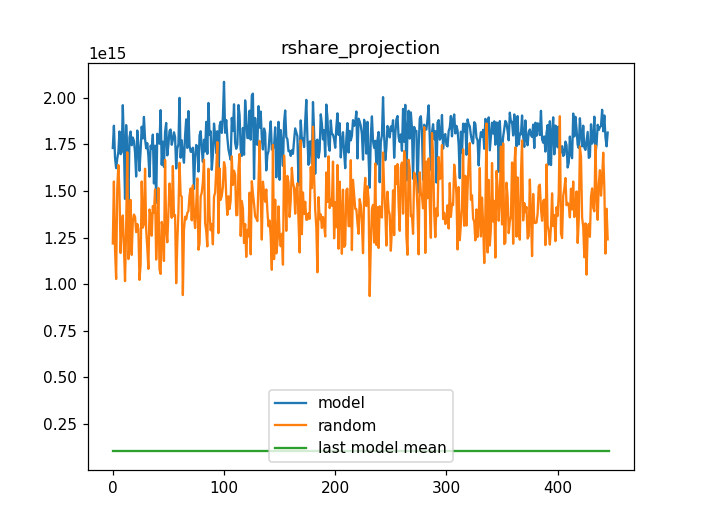

<IPython.core.display.Javascript object>


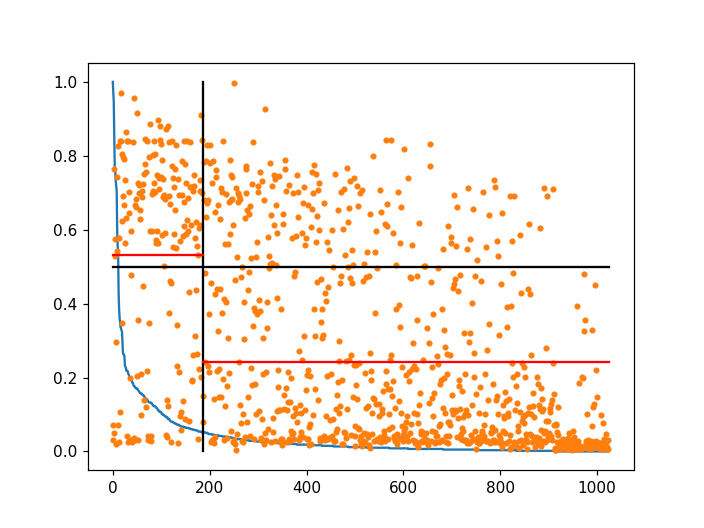

676 161 | 0.807646
48 139 | 0.743316

simple_projection: Daily good votes: 1236, bad: 1490, total >= 2726
voting_projection:
	Daily good posts: 1663, bad: 7746
	Daily good votes: 90, bad: 110
Rshares projection: 2.09e+15 vs. random: 1.9e+15
CPU times: user 2min 17s, sys: 0 ns, total: 2min 17s
Wall time: 2min 17s


In [86]:
%%time
good_posts_stats = show_projection(val_data, vis_data_val, y_pred_val, y_true_val, rshare_projection, posts_no_hr1)

<IPython.core.display.Javascript object>


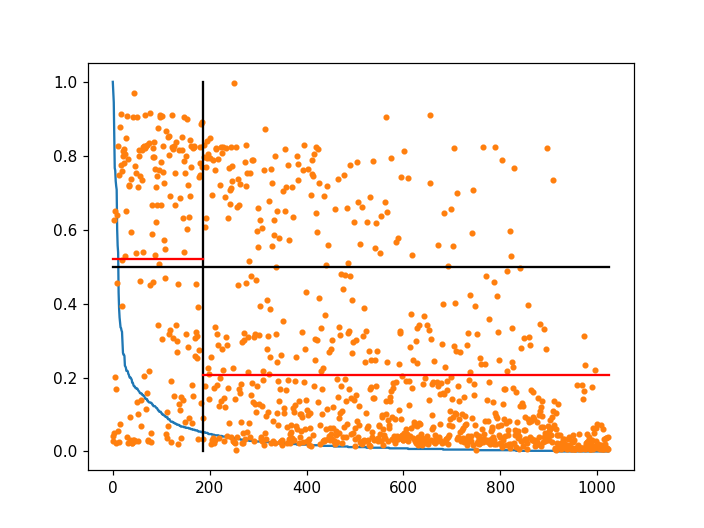

720 117 | 0.860215
59 128 | 0.684492

simple_projection: Daily good votes: 1138, bad: 1082, total >= 2221
voting_projection:
	Daily good posts: 1663, bad: 7746
	Daily good votes: 102, bad: 98
Rshares projection: 2.02e+15 vs. random: 1.49e+15


187

In [76]:
plot_it(index=126, vis_data=vis_data_val, y_pred=y_pred_val, y_true=y_true_val)

### How does subsampling fare?

rshare_projection: Best model is #3 with metric value: 2.531e+15


<IPython.core.display.Javascript object>


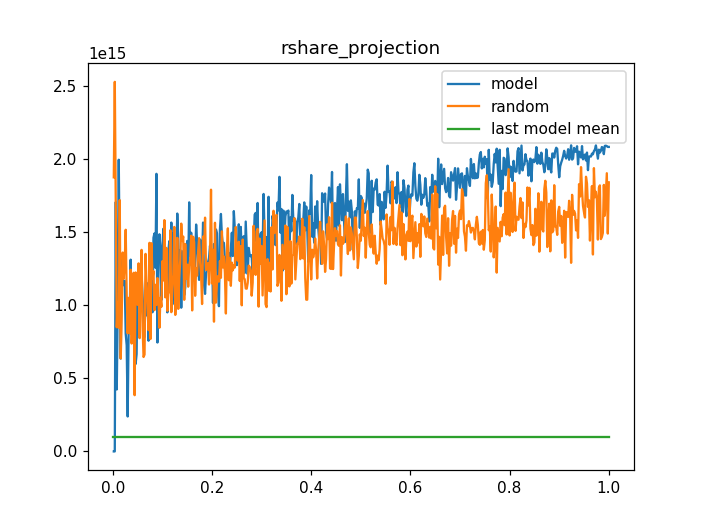

CPU times: user 2min 8s, sys: 84 ms, total: 2min 8s
Wall time: 2min 8s


In [61]:
%%time
good_posts_stats = show_projection_subsample(
    val_data, vis_data_val, y_pred_val, y_true_val, rshare_projection, epoch=100, num_subsample=500
)

rshare_projection: Best model is #192 with metric value: 1.944e+15


<IPython.core.display.Javascript object>


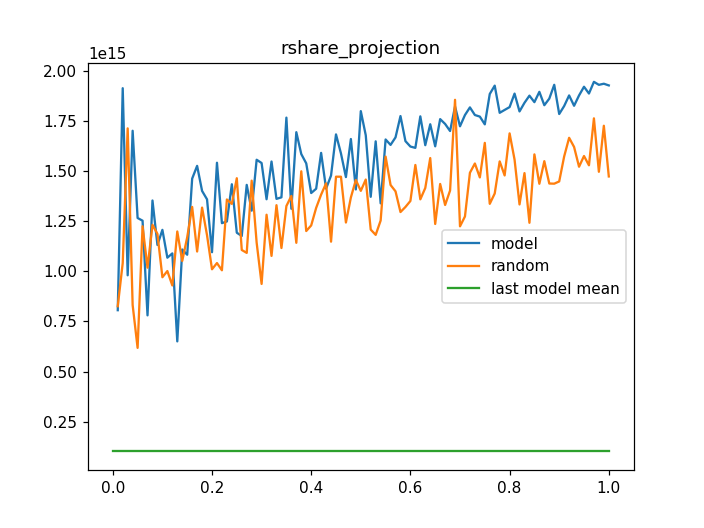

In [62]:
good_posts_stats = show_projection_subsample(
    val_data, vis_data_val, y_pred_val, y_true_val, rshare_projection, epoch=-1, num_subsample=100
)

# TBD: Test set analysis

### Create test set

In [37]:
test_data = create_eval_set(data_bin, "training_configs/default_training_setup.json", 'test')

Using:
	TEST2TRAIN_RATIO: 0.0250
	BATCH_SIZE: 8
	TEST_SAMPLES: 1024
test set size: 1024


### Load model results for test set

In [38]:
# TBD

In [ ]:
%%time
good_posts_stats = show_projection(test_data, rshare_projection)